# Trabalho de INF 791 - Redes Complexas
Paula Teresa Mota Gibrim
<b>Matrícula:</b> ES 90366

## Introdução
O trabalho prático, inicialmente, consistia do uso de APIs para captação de dados e então, modelagem do grafo usando NetworkX. Infelizmente, tive muita dificuldade para captação desses dados. A ideia inicial era coletar dados do Twitter de usuários que acompanharam a semi-final do campeonato mundial de Counter-Strike: Global Offensive, o IEM Rio 2022, partida entre Fúria e Heroic, e analisar novas conexões entre esses usuários após a partida. Todavia, após modificações das políticas de uso da API não permitiam mais a busca de tweets por palavras-chave (e todas as modificações que consegui moldar do problema, eu obtive o mesmo resultado).

[Aqui você visualiza o resultado das buscas](https://cdn.discordapp.com/attachments/1019674912333504614/1108094286978875522/image.png)

Diante disso, tentei solicitar acesso à API para Projetos Estudantis, que requer um tempo maior de análise, e não obtive resposta. Solicitei também a API do TikTok, mas demoraram 3 semanas para dar um retorno, e o mesmo foi negativo. Tentei buscar outras APIs, e todas tinham os mesmos problemas: não faziam nenhuma coleta de dados da rede, mas sim do usuário.

Analisando essa situação, optei por avançar no trabalho sem coletar meus próprios dados, utilizando um dataset já coletado e fazendo a modelagem em cima dele. Sendo assim, o dataset escolhido visa medir a probabilidade de conectividade entre usuários de diferentes países, considerando os dados de usuários do Facebook.

## Rede analisada
O dataset selecionado é baseado em dados anônimos coletados no Facebook. Cada usuário é atribuído a um país baseado nas informações disponibilizadas em seu perfil, e de conexões de seus dispositivos. Diante disso, o SCI (Social Connectedness Index) entre dois locais <i>i</i> e <i>j</i> é calculado como:
$$
    SCI_{i,j} = \frac{\textrm{FB_Connections}_{i,j}}{\textrm{FB_Users}_{i} \times \textrm{FB_Users}_{j}}
$$
onde $\textrm{FB_Users}_{i}$ e $\textrm{FB_Users}_{j}$ se referem à quantidade de usuários do Facebook no país <i>i</i> e <i>j</i>, e $\textrm{FB_Connections}_{i,j}$ é o número total de conexões entre indivíduos desses dois países.

### Importações
Primeiramente, faremos as importações das bibliotecas necessárias para o trabalho.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Agora vamos carregar o dataset selecionado, e criar o grafo.

In [3]:
data = pd.read_csv('data.tsv', sep='\t')

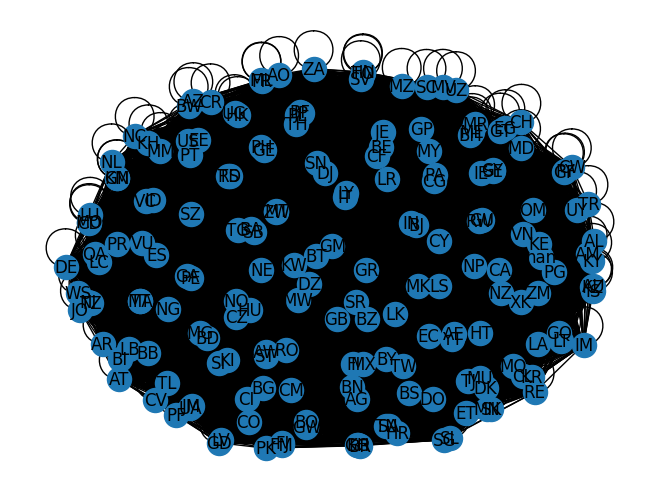

In [5]:
# Criar o grafo
graph = nx.Graph()
user_loc_list = data['Source'].tolist()
fr_loc_list = data['Target'].tolist()
graph.add_nodes_from(user_loc_list)
for i in range(0, len(user_loc_list)):
    graph.add_edge(user_loc_list[i], fr_loc_list[i])

nx.draw(graph, with_labels=True)